LOADING FILES AND LIBRARIES



In [ ]:
!pip install pandas scikit-learn

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving news-article-categories.csv to news-article-categories.csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re

In [ ]:
# Load the dataset
df = pd.read_csv('/content/news-article-categories.csv')
print(df.head())

In [ ]:
df

,category,title,body
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,"In October 2017, Carolyn Kramer received a dis..."
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,This week I talked with actor Jeff Hiller abou...
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,The New Yorker is taking on President Donald T...
3,ARTS & CULTURE,Man Surprises Girlfriend By Drawing Them In Di...,"Kellen Hickey, a 26-year-old who lives in Huds..."
4,ARTS & CULTURE,This Artist Gives Renaissance-Style Sculptures...,There’s something about combining the traditio...
...,...,...,...
6872,WOMEN,Casually Fearless: Why Millennials Are Natural...,I still think about that Tuesday night dinner ...
6873,WOMEN,Happy Birthday To Us,I remember the morning of my high school gradu...
6874,WOMEN,The Culture of Love,"My husband, Gene, doesn't wear pajamas. I aske..."
6875,WOMEN,"Carpe Diem, Oprah Style","\nBy AntonioGuillem, via ThinkStock\nBy Lisa ..."


PREPROCESSING STEPS

In [ ]:
df.isnull().sum()

,0
category,0
title,0
body,5


In [ ]:
df = df.dropna()
df = df.dropna(axis=1)

In [ ]:
df

,category,title,body
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,"In October 2017, Carolyn Kramer received a dis..."
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,This week I talked with actor Jeff Hiller abou...
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,The New Yorker is taking on President Donald T...
3,ARTS & CULTURE,Man Surprises Girlfriend By Drawing Them In Di...,"Kellen Hickey, a 26-year-old who lives in Huds..."
4,ARTS & CULTURE,This Artist Gives Renaissance-Style Sculptures...,There’s something about combining the traditio...
...,...,...,...
6872,WOMEN,Casually Fearless: Why Millennials Are Natural...,I still think about that Tuesday night dinner ...
6873,WOMEN,Happy Birthday To Us,I remember the morning of my high school gradu...
6874,WOMEN,The Culture of Love,"My husband, Gene, doesn't wear pajamas. I aske..."
6875,WOMEN,"Carpe Diem, Oprah Style","\nBy AntonioGuillem, via ThinkStock\nBy Lisa ..."


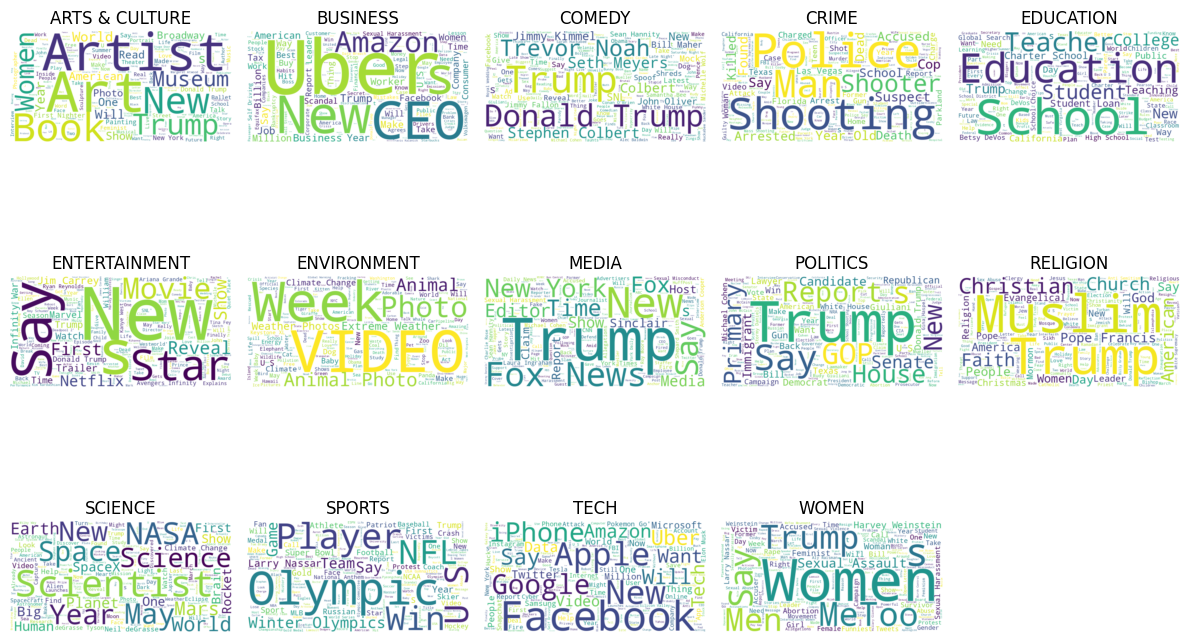

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

category_words = {}
for category in df['category'].unique():
    category_words[category] = ' '.join(df['title'][df['category'] == category].astype(str).tolist())

plt.figure(figsize=(12, 8))
for i, category in enumerate(df['category'].unique()):
    plt.subplot(3, 5, i+1)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_words[category])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(category)
_ = plt.tight_layout()

In [ ]:
df['category'].value_counts()

,count
category,
ARTS & CULTURE,1001
BUSINESS,501
ENTERTAINMENT,501
RELIGION,501
POLITICS,501
ENVIRONMENT,501
WOMEN,501
TECH,501
SPORTS,501


In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['category'])
df['label'] = label_encoder.transform(df['category'])

In [ ]:
df['body']=df['body'].str.lower()
df.head()

,category,title,body,label
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,in october 2017 carolyn kramer received distur...,0
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,this week i talked actor jeff hiller hit off b...,0
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,the new yorker taking president donald trump a...,0
3,ARTS & CULTURE,Man Surprises Girlfriend By Drawing Them In Di...,kellen hickey 26-year-old life hudson wisconsi...,0
4,ARTS & CULTURE,This Artist Gives Renaissance-Style Sculptures...,there ’ something combining traditional uptigh...,0


In [ ]:
#For removing HTML tags
from bs4 import BeautifulSoup

def html_tags_present(text):
     if isinstance(text, str):
        soup = BeautifulSoup(text, 'html.parser')
        return bool(soup.find())
     else:
        return False


df['html_tags_present'] = df['body'].apply(html_tags_present)

count_true = df['html_tags_present'].sum()

df = df.drop(df[df['html_tags_present']].index)
df = df.drop('html_tags_present', axis=1)


<ipython-input-20-e236a7c94a14>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
# For removing URLS
import re

def remove_url(text):
    if isinstance(text, str):
        pattern = re.compile(r'https?://\S+|www\.\S+')
        return pattern.sub(r'', text)
    else:
        return text

df['body'] = df['body'].apply(remove_url)

In [ ]:
# For removing emojis
import regex

def has_emoji(text):
    if isinstance(text, str):
        emoji_pattern = regex.compile(r'\p{Emoji}', flags=regex.UNICODE)
        return bool(emoji_pattern.search(text))
    else:
        return False

has_emojis = df['body'].apply(has_emoji)

# has_emojis.sum()

def remove_emojis(text):
    if isinstance(text, str):
        emoji_pattern = regex.compile(r'\p{Emoji}', flags=regex.UNICODE)
        return emoji_pattern.sub('', text)
    else:
        return text


df['body'] = df['body'].apply(remove_emojis)

has_emojis = df['body'].apply(has_emoji)
has_emojis.sum()


0

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

nltk.download('punkt')

from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

def DataPrep(text):

    if isinstance(text, str):
        # Tokenization
        tokens = nltk.word_tokenize(text)

        # Remove punctuation
        punc = list(punctuation)
        words = [w for w in tokens if w not in punc]

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if w not in stop_words]

        # Lemmatization
        words = [lemma.lemmatize(w) for w in words]

        # Join words back into text
        text = ' '.join(words)

        return text
    else:
        return ''

cleaned = df['body'] = df['body'].apply(DataPrep)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df.head()

,category,title,body,label
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,october carolyn kramer received disturbing pho...,0
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,week talked actor jeff hiller hit broadway pla...,0
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,new yorker taking president donald trump asked...,0
3,ARTS & CULTURE,Man Surprises Girlfriend By Drawing Them In Di...,kellen hickey -year-old life hudson wisconsin ...,0
4,ARTS & CULTURE,This Artist Gives Renaissance-Style Sculptures...,’ something combining traditional uptight look...,0


In [ ]:
df

,category,title,body,label
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,october carolyn kramer received disturbing pho...,0
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,week talked actor jeff hiller hit broadway pla...,0
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,new yorker taking president donald trump asked...,0
3,ARTS & CULTURE,Man Surprises Girlfriend By Drawing Them In Di...,kellen hickey -year-old life hudson wisconsin ...,0
4,ARTS & CULTURE,This Artist Gives Renaissance-Style Sculptures...,’ something combining traditional uptight look...,0
...,...,...,...,...
6872,WOMEN,Casually Fearless: Why Millennials Are Natural...,still think tuesday night dinner -year-old dau...,13
6873,WOMEN,Happy Birthday To Us,remember morning high school graduation clearl...,13
6874,WOMEN,The Culture of Love,husband gene n't wear pajama asked told never ...,13
6875,WOMEN,"Carpe Diem, Oprah Style",antonioguillem via thinkstock lisa o'donoghue-...,13


FEATURE ENGINEERING

In [ ]:
# Combine cleaned headline and description for feature extraction
x = df['body'] = df['body'].apply(DataPrep)

# Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X =  vectorizer.fit_transform(x.values.astype('U'))
y = df['label']

SPLITTING THE DATA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

BALANCING THE DATA

In [ ]:
# Import ADASYN from imbalanced-learn
from imblearn.over_sampling import ADASYN

adasyn = ADASYN()

X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

os = pd.DataFrame(list(zip([x[0] for x in X_resampled], y_resampled)), columns=['body', 'Label'])

os['Label'].value_counts()


,count
Label,
10,824
2,818
13,811
3,803
0,800
5,793
7,783
4,777
6,769


In [ ]:
df

,category,title,body,label
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,october carolyn kramer received disturbing pho...,0
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,week talked actor jeff hiller hit broadway pla...,0
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,new yorker taking president donald trump asked...,0
3,ARTS & CULTURE,Man Surprises Girlfriend By Drawing Them In Di...,kellen hickey -year-old life hudson wisconsin ...,0
4,ARTS & CULTURE,This Artist Gives Renaissance-Style Sculptures...,’ something combining traditional uptight look...,0
...,...,...,...,...
6872,WOMEN,Casually Fearless: Why Millennials Are Natural...,still think tuesday night dinner -year-old dau...,13
6873,WOMEN,Happy Birthday To Us,remember morning high school graduation clearl...,13
6874,WOMEN,The Culture of Love,husband gene n't wear pajama asked told never ...,13
6875,WOMEN,"Carpe Diem, Oprah Style",antonioguillem via thinkstock lisa o'donoghue-...,13


LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Make predictions
y_pred = lr_model.predict(X_test)


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7927


In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       201
           1       0.71      0.70      0.70       100
           2       0.79      0.65      0.72        75
           3       0.78      0.78      0.78        60
           4       0.81      0.83      0.82        98
           5       0.76      0.78      0.77       100
           6       0.78      0.87      0.82       100
           7       0.84      0.69      0.76        70
           8       0.74      0.78      0.76       100
           9       0.87      0.88      0.88       100
          10       0.88      0.84      0.86        70
          11       0.91      0.88      0.89       100
          12       0.81      0.75      0.78       101
          13       0.71      0.58      0.64       100

    accuracy                           0.79      1375
   macro avg       0.80      0.78      0.79      1375
weighted avg       0.79      0.79      0.79      1375



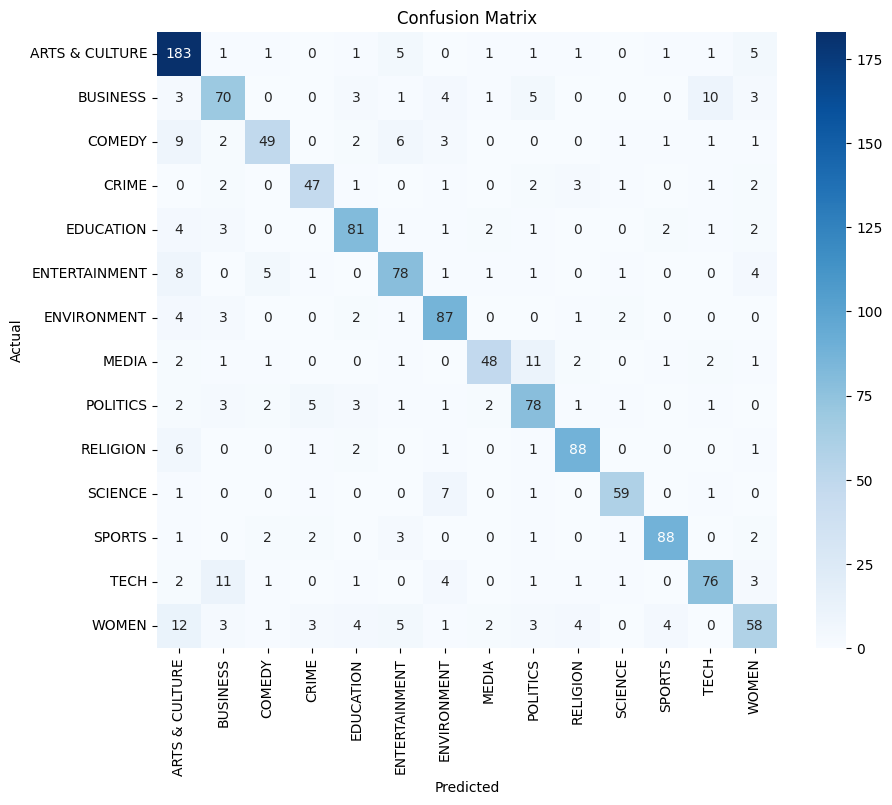

In [ ]:
# Confusion matrix
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
label_names = df['category'].unique()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

SVM MODEL

In [ ]:
# Train the SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_resampled, y_resampled)

SVC(random_state=42)

In [ ]:

print("Model Summary:")
print("-" * 20)
print("Model Type:", type(svm_model))
print("Kernel:", svm_model.kernel)
print("Number of support vectors for each class:", svm_model.n_support_)
print("-" * 20)



Model Summary:
--------------------
Model Type: <class 'sklearn.svm._classes.SVC'>
Kernel: rbf
Number of support vectors for each class: [707 585 481 323 368 585 560 451 534 455 433 422 521 535]
--------------------


In [ ]:
# Make predictions
y_pred = svm_model.predict(X_test)
y_pred

array([ 4,  2,  2, ..., 13,  0,  2])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8044


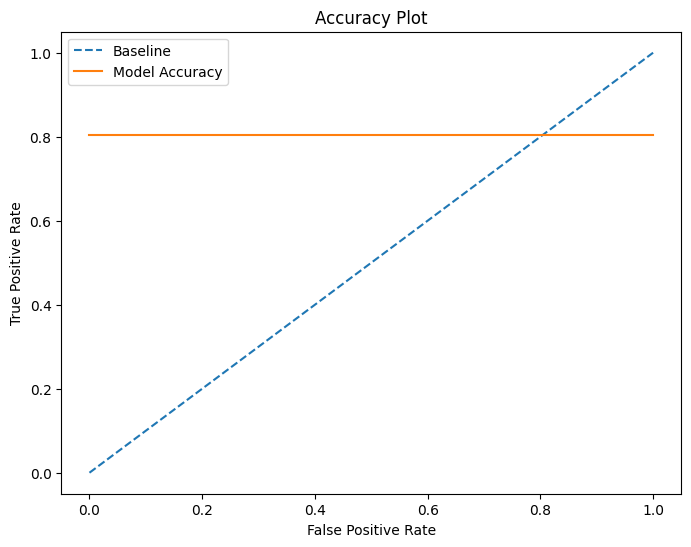

In [ ]:

import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='Baseline')
plt.plot([0, 1], [accuracy, accuracy], label='Model Accuracy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Accuracy Plot')
plt.legend()
plt.show()


In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       201
           1       0.73      0.73      0.73       100
           2       0.83      0.65      0.73        75
           3       0.82      0.83      0.83        60
           4       0.87      0.82      0.84        98
           5       0.80      0.81      0.81       100
           6       0.81      0.87      0.84       100
           7       0.82      0.71      0.76        70
           8       0.76      0.83      0.79       100
           9       0.91      0.85      0.88       100
          10       0.88      0.84      0.86        70
          11       0.91      0.87      0.89       100
          12       0.82      0.76      0.79       101
          13       0.71      0.64      0.67       100

    accuracy                           0.80      1375
   macro avg       0.82      0.79      0.80      1375
weighted avg       0.81      0.80      0.80      1375



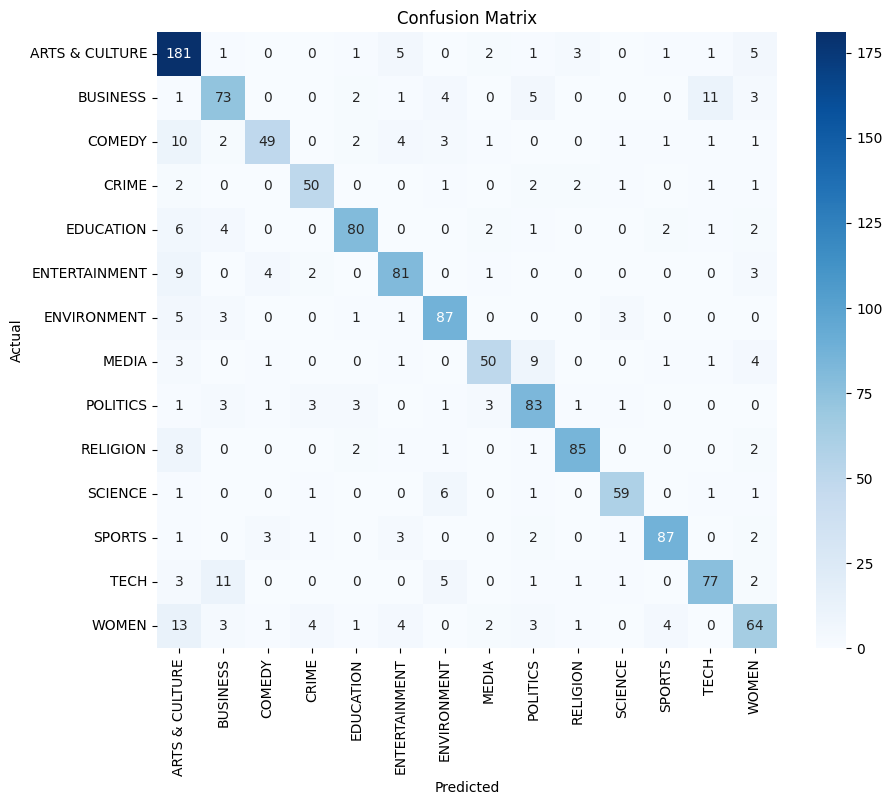

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
label_names = df['category'].unique()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=1000, random_state=20)
rf_model.fit(X_resampled, y_resampled)


RandomForestClassifier(n_estimators=1000, random_state=20)

In [ ]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*1.3:.4f}")

Accuracy: 0.8911


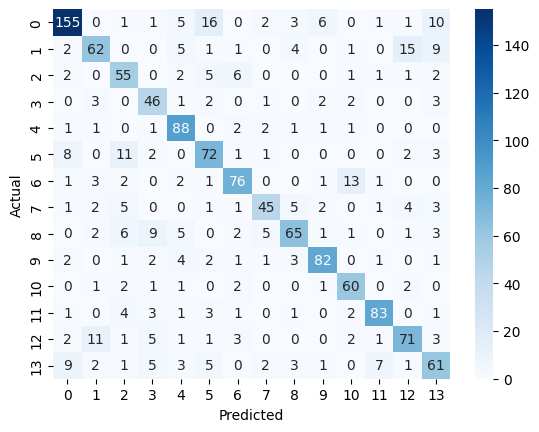

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.7535
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       201
           1       0.75      0.63      0.68       100
           2       0.76      0.63      0.69        75
           3       0.55      0.92      0.69        60
           4       0.74      0.86      0.79        98
           5       0.62      0.78      0.69       100
           6       0.80      0.78      0.79       100
           7       0.67      0.80      0.73        70
           8       0.72      0.62      0.67       100
           9       0.89      0.85      0.87       100
          10       0.78      0.84      0.81        70
          11       0.92      0.80      0.86       100
          12       0.79      0.69      0.74       101
          13       0.59      0.53      0.56       100

    accuracy                           0.75      1375
   macro avg       0.75      0.75      0.74      1375
weighted avg       0.77      0.75      0.75      1375



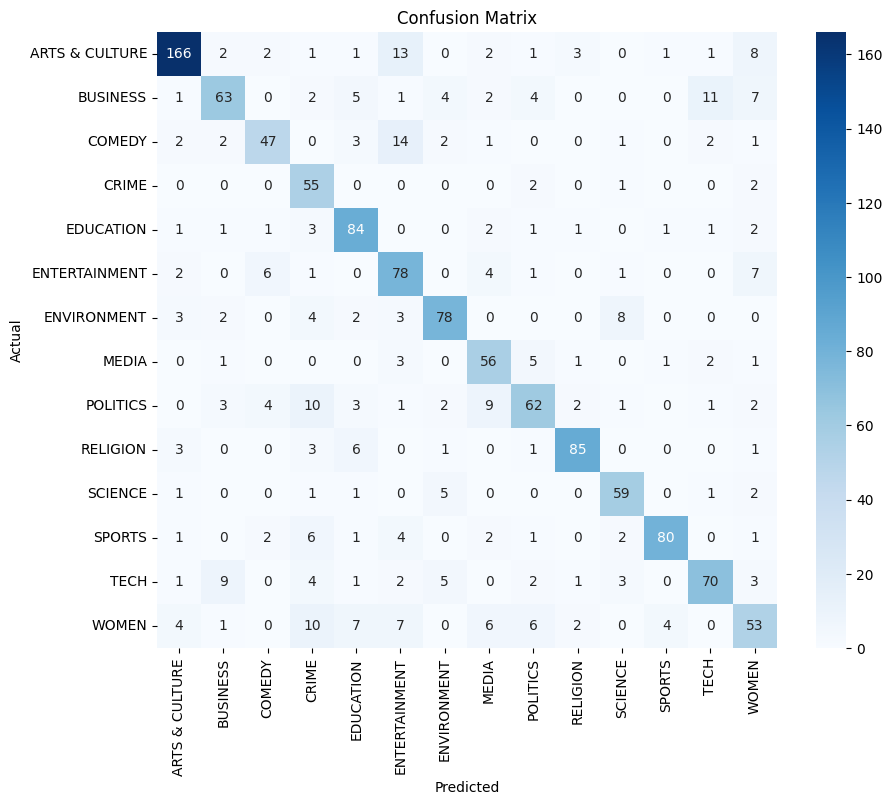

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
label_names = df['category'].unique()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()